# Training a CNN on only coordinates

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from src.dataset import AminoAcidDataset
from src.model import AminoAcidCNN_coord_only
from src.train import train_model, evaluate_model
from src.visual import plot_confusion_matrix, plot_aa_distributions

## 1. Again load the data and initialize the model + training

In [2]:
# Create an instance of the dataset
dataset = AminoAcidDataset('data/amino_acids_2_0A_augmented.pdb', padding=True)
print(f"Number of samples: {len(dataset)}")

# Split the dataset into training and testing sets using an 80/20 split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

Number of samples: 294502


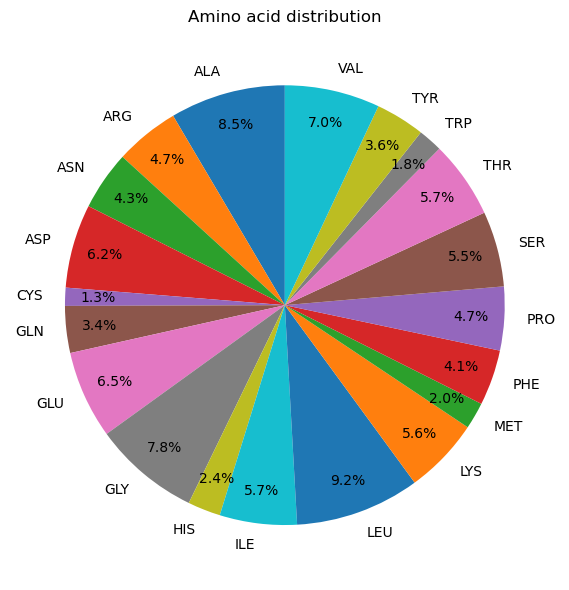

In [3]:
figure = plot_aa_distributions(dataset)
plt.tight_layout()
plt.show()

In [4]:
N, M = dataset.input_shape
model = AminoAcidCNN_coord_only(input_channels=1, # Since we added an extra dimension for batch and channel
                                input_height=N, # Number of atoms
                                input_width=3) # 3 coordinates

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Create data loaders for training and testing
train_dataloader = DataLoader(train_dataset, batch_size=1000, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=1000, shuffle=True, drop_last=True)

# Train the models
#training_dict = train_model(model=model, criterion=criterion, optimizer=optimizer, data_loader=train_dataloader, n_epochs=3, coord_only=True)

# Load the training dict (pretrained model)
training_dict = torch.load('models/training_dict_coord_only.pt', map_location=torch.device('cpu'))
# Update the dataloaders to make sure we dont evaluate on test data
test_dataloader, train_dataloader = training_dict['test_loader'], training_dict['train_loader'] 
# Update the initialized model with the loaded model
model = training_dict['model']

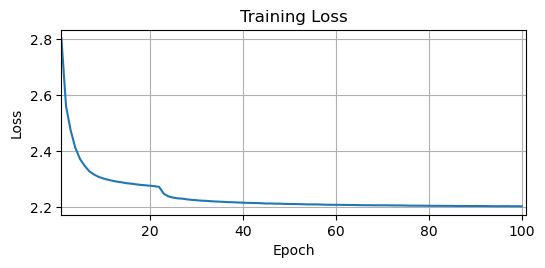

In [6]:
plt.figure(figsize=(6, 2.4))
plt.plot(range(1, len(training_dict['total_loss'])+1), training_dict['total_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.xlim(1, len(training_dict['total_loss'])+1)
plt.grid()
plt.show()


## 2. Evaluate the performance

{'accuracy': 0.8785238265991211, 'precision': 0.7359828948974609, 'recall': 0.7916378378868103}


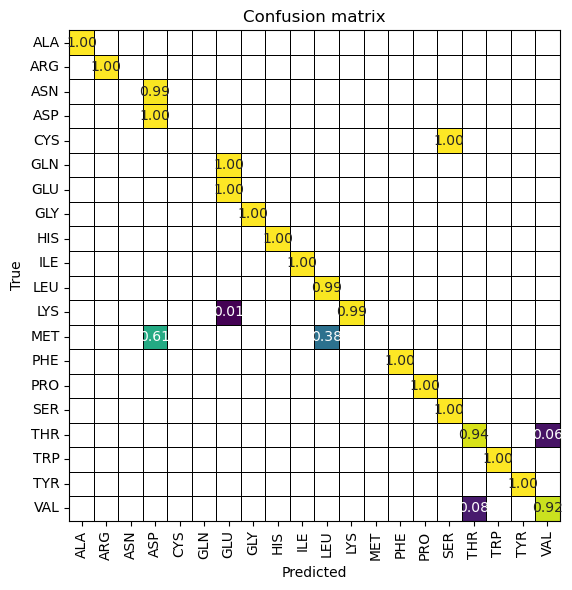

In [7]:
# Evaluate the model
print(evaluate_model(model, test_dataloader,coord_only=True))

# Plot confusion matrix
figure = plot_confusion_matrix(model, test_dataloader, coord_only=True)
plt.tight_layout()
plt.show()

# What is happening & how can we improve?

We see in our confusion matrix that the model now is mixing up residues way more often than before and for some residues, never even recognizes them. **Why is this?** As shown in the README file, some residues such as ASN and ASP or SER and CYS and GLN and GLU have an identical arangement of heavy atoms, only distinguishing themselves by the type of heavy atoms in these positions and perhaps their caracteristic bond differences. Moreover, underrepresentation of certain residues and overrepresentation of others may be compounding this effect.

Since the central difference in the residuess we mix up can only be the bond distances, a simple approach we can use here is to use only amino acids reported in the PDB with high resolution.

For this we can load the dataset with a resolution cutoff at 1.5 Å provided in data.

However we should be clear about the fact that very likely problems like the classification of Cysteine as Serine are due to the low repressentation of Cysteines in our dataset (~1.3%).



Number of samples: 106470


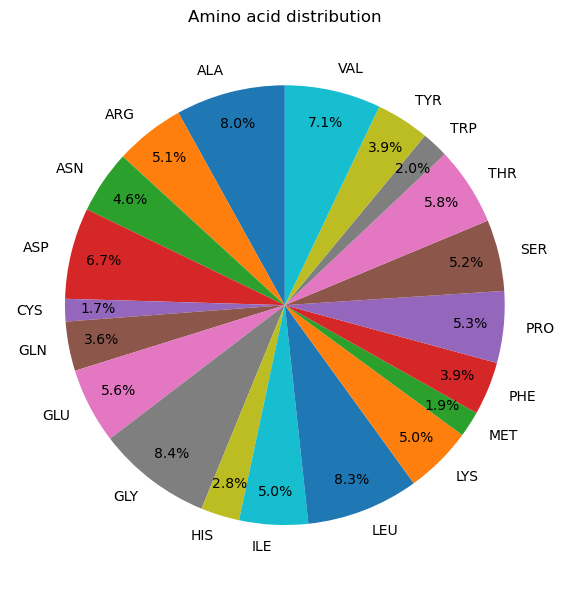

In [8]:
# Create an instance of the dataset
dataset = AminoAcidDataset('data/amino_acids_1_5A_augmented.pdb', padding=True)
print(f"Number of samples: {len(dataset)}")

# Split the dataset into training and testing sets using an 80/20 split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
figure = plot_aa_distributions(dataset)
plt.tight_layout()
plt.show()

In [9]:
N, M = dataset.input_shape
model = AminoAcidCNN_coord_only(input_channels=1, # Since we added an extra dimension for batch and channel
                                input_height=N, # Number of atoms
                                input_width=3) # 3 coordinates

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Create data loaders for training and testing
train_dataloader = DataLoader(train_dataset, batch_size=1000, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=1000, shuffle=True, drop_last=True)

# Train the models
#training_dict = train_model(model=model, criterion=criterion, optimizer=optimizer, data_loader=train_dataloader, n_epochs=3, coord_only=True)

# Load the training dict (pretrained model)
training_dict = torch.load('models/training_dict_coord_only_high_res.pt', map_location=torch.device('cpu'))
# Update the dataloaders to make sure we dont evaluate on test data
test_dataloader, train_dataloader = training_dict['test_loader'], training_dict['train_loader'] 
# Update the initialized model with the loaded model
model = training_dict['model']

{'accuracy': 0.8236190676689148, 'precision': 0.7416868209838867, 'recall': 0.7521895170211792}


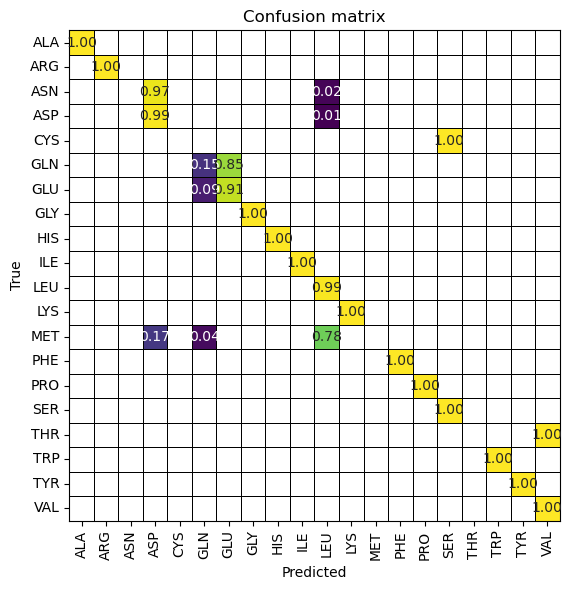

In [10]:
# Evaluate the model
print(evaluate_model(model, test_dataloader,coord_only=True))

# Plot confusion matrix
figure = plot_confusion_matrix(model, test_dataloader, coord_only=True)
plt.tight_layout()
plt.show()

### We  can further refine this by lowering the batch size during training from 1000 to 100 (increasing training time)

In [11]:
N, M = dataset.input_shape
model = AminoAcidCNN_coord_only(input_channels=1, # Since we added an extra dimension for batch and channel
                                input_height=N, # Number of atoms
                                input_width=3) # 3 coordinates

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Create data loaders for training and testing
train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=100, shuffle=True, drop_last=True)

# Train the models
#training_dict = train_model(model=model, criterion=criterion, optimizer=optimizer, data_loader=train_dataloader, n_epochs=3, coord_only=True)

# Load the training dict (pretrained model)
training_dict = torch.load('models/training_dict_coord_only_high_res_low_batch.pt', map_location=torch.device('cpu'))
# Update the dataloaders to make sure we dont evaluate on test data
test_dataloader, train_dataloader = training_dict['test_loader'], training_dict['train_loader'] 
# Update the initialized model with the loaded model
model = training_dict['model']

{'accuracy': 0.8739150762557983, 'precision': 0.78546142578125, 'recall': 0.7944743037223816}


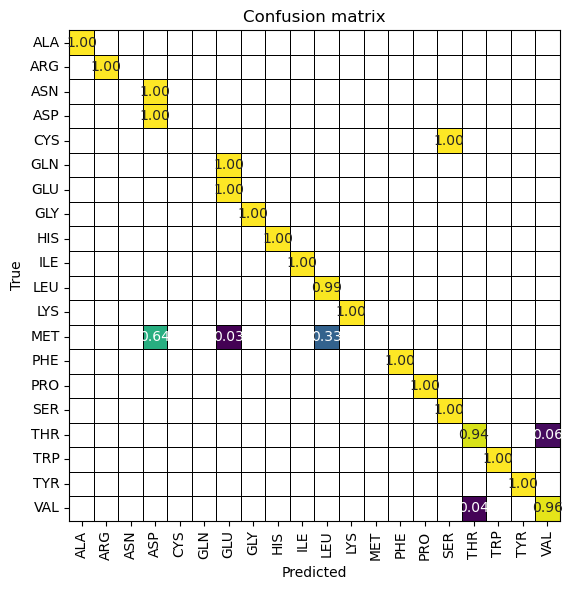

In [12]:
# Evaluate the model
print(evaluate_model(model, test_dataloader,coord_only=True))

# Plot confusion matrix
figure = plot_confusion_matrix(model, test_dataloader, coord_only=True)
plt.tight_layout()
plt.show()

### We see that we can attain similar accuracy and recall while significantly improving precision. Also, this seems to fix our problems with the THR residue, but not for others. More steps could involve adjusting the learning rate or increasing training data / epochs. 